# Image Segmentation with U-Net

U-Net is a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image.

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

Region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

## Load and Split the Data

In [2]:
import os

image_path = "data/CameraRGB"       # Training data
mask_path = "data/CameraMask"       # Labelled data
image_list = [os.path.join(image_path, x) for x in os.listdir(image_path)]
mask_list = [os.path.join(mask_path, x) for x in os.listdir(mask_path)]

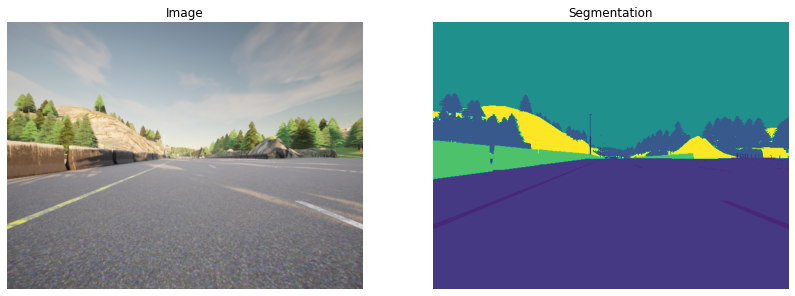

In [3]:
import imageio
import matplotlib.pyplot as plt

# Image index
idx = 2

# Display image and its masked version (labelled version)
# Image
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
plt.title('Image')
img = imageio.imread(image_list[idx])
plt.imshow(img)
plt.axis('off')

# Masked
plt.subplot(1,2,2)
plt.title('Segmentation')
mask = imageio.imread(mask_list[idx])
plt.imshow(mask[:, :, 0])
plt.axis('off')
plt.show()

In [4]:
# Create the dataset by pairing training-label images
dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))

In [5]:
# Visualise 1 element in the dataset
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/CameraRGB/002128.png', shape=(), dtype=string)
tf.Tensor(b'data/CameraMask/002128.png', shape=(), dtype=string)


## Preprocess Your Data

Normally, we normalize the image values by dividing them by `255`. This sets them between `0` and `1`. However, using `tf.image.convert_image_dtype` with `tf.float32` will set them between `0` and `1`, so there's no need to further divide them by `255`.

In [6]:
def preprocess_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)               # Decode a PNG image into a tensor
    img = tf.image.convert_image_dtype(img, tf.float32)      # Normalize the image pixel values
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)             # Decode a PNG image into a tensor
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  # Only retain the biggest value among 3 channels in each pixel
    
    return img, mask

In [7]:
def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    return input_image, input_mask

In [8]:
image_ds = dataset.map(preprocess_path)
processed_image_ds = image_ds.map(preprocess)

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

(480, 640, 3)
(480, 640, 1)


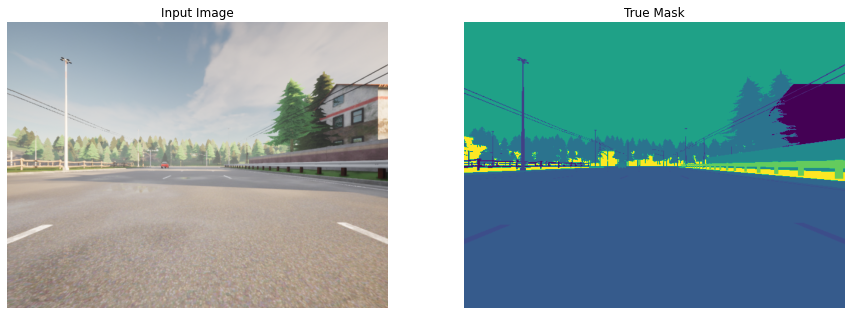

In [10]:
# Visualize shape and data of the original training set
for image, mask in image_ds.take(1):
    print(image.shape)
    print(mask.shape)
    display([image, mask])

(96, 128, 3)
(96, 128, 1)


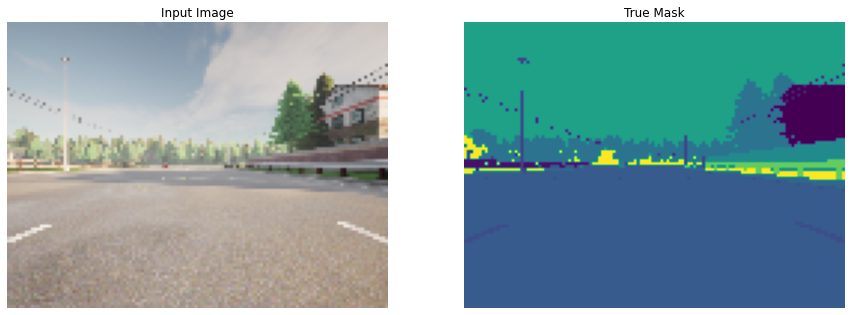

In [11]:
# Visualize the shape and data of the preprocessed training set
for image, mask in processed_image_ds.take(1):
    print(image.shape)
    print(mask.shape)
    display([image, mask])

## Reproduce U-Net model
### a - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

#### Note: 
Due to computational constraints, we will use just 1/2 number of filters as that in the original U-Net model (the U-Net starts with 64 filters, while we start with 32 filters only)

In [11]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters,                  # Number of filters
                  3,                          # Kernel size   
                  activation='relu',          
                  padding='same',             # Keep output and input with the same dimension
                  kernel_initializer='he_normal')(inputs)    # Initialise layer weights with he_normal distribution
    conv = Conv2D(n_filters, 
                  3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(2, strides=2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [12]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,                 # Number of filters
                 3,                         # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,                # Number of filters
                 3,                         # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,                # Number of filters
                 3,                         # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

## Build the Model

There are 23 possible labels for each pixel in this self-driving car dataset. 

In [13]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    
    # Downsampling module
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) 
    
    # Upsampling module
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    
    # Final feature mapping module
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, activation='relu', padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [14]:
img_shape = (96, 128, 3)
unet = unet_model(img_shape)

In [15]:
unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 64, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## Compile the Model

Both SparseCategoricalCrossentropy and CategoricalCrossentropy are used for multiclass classification task. But we use SparseCategoricalCrossentropy loss for U-Net because the labels are provided as integers. If the labels are provided as one-hot, we will have to use CategoricalCrossentropy instead.

In [20]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    # Use SparseCategoricalCrossentropy because y_label is presented as integers, not one-hot
              metrics=['accuracy'])

<a name='4'></a>
## 4 - Train the Model

In [21]:
train_dataset = processed_image_ds.cache().shuffle(buffer_size=500).batch(batch_size=32)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=40)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 16s 477ms/step - loss: 2.2231 - accuracy: 0.3943
Epoch 2/40
34/34 [==============================] - 1s 41ms/step - loss: 0.9396 - accuracy: 0.7748
Epoch 3/40
34/34 [==============================] - 1s 41ms/step - loss: 0.6214 - accuracy: 0.8248
Epoch 4/40
34/34 [==============================] - 1s 42ms/step - loss: 0.5555 - accuracy: 0.8465
Epoch 5/40
34/34 [==============================] - 1s 41ms/step - loss: 0.4752 - accuracy: 0.8707
Epoch 6/40
34/34 [==============================] - 1s 41ms/step - loss: 0.4031 - accuracy: 0.8856
Epoch 7/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3437 - accuracy: 0.8992
Epoch 8/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3094 - accuracy: 0.9106
Epoch 9/40
34/34 [==============================] - 1s 40ms/step - loss: 0.2960 - acc

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [40]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)     # After the model output the probabilities of 23 classes for each pixel, we will just take the index of the class with the highest probability
    pred_mask = pred_mask[..., tf.newaxis]        # Add an extra axis at the end
    return pred_mask

## Plot Model Accuracy

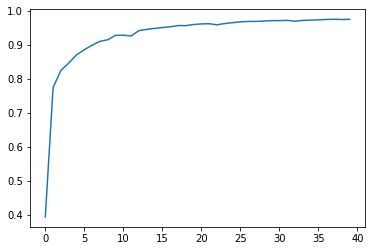

In [23]:
plt.plot(model_history.history["accuracy"])

## Show Predictions 

Check your predicted masks against the true mask and the original input image:

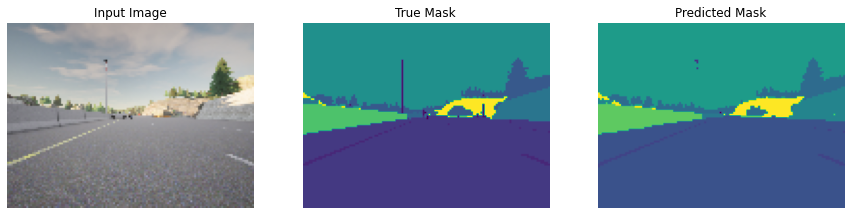

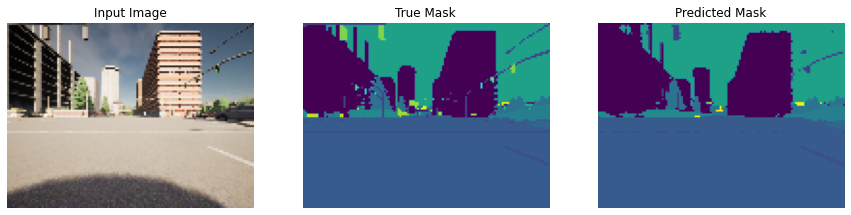

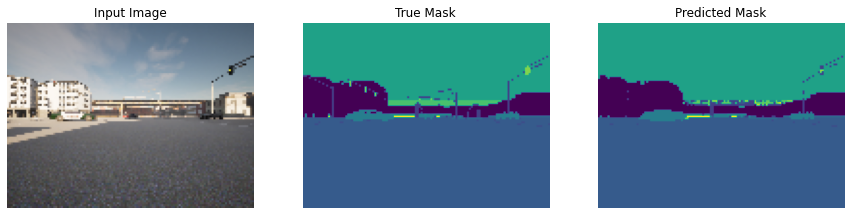

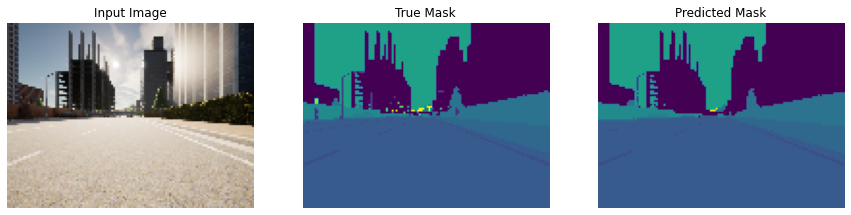

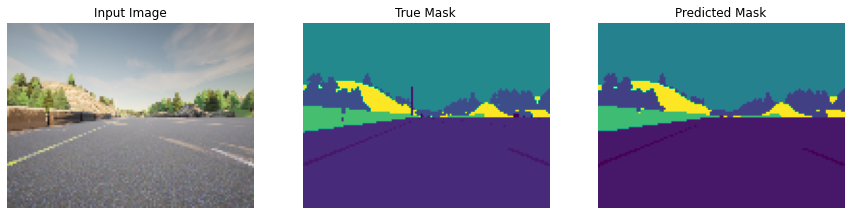

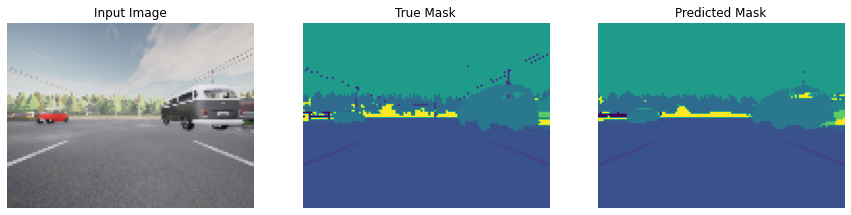

In [45]:
num = 6
for image, mask in train_dataset.take(num):
    pred_mask = unet.predict(image)
    pred_mask = create_mask(pred_mask)
    display([image[0], mask[0], pred_mask[0]])